# Drivers

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/drivers.ipynb) (requires google account)


The TOPFARM platform actually relies on the **OpenMDAO library**, an open-source platform which aims to build new analysis and optimization tools to be employed in a variety of mathematical and engineering problems. In particular, the word **"driver"** is an OpenMDAO technical term which refers to a series of instructions operating on a workflow.

In the simplest case, a driver can execute an entire workflow; in the case of optimization, a driver is usually an optimization procedure which operates over the workflow until (ideally) an optimal solution is found. When the problem has a particularly complex formulation, there may be multiple drivers acting on sub-groups of a workflow.  For instance, in an optimization under uncertainty (OUU) problem, there is usually an uncertainty quantification/analysis driver operating on a workflow nested within a larger optimization workflow.

This tutorial provides a basic introduction to the application of openMDAO drivers in the optimization of wind farm design as solved by TOPFARM. Such drivers can be based both on iterative step-by-step algorithms or metaheuristic/heuristic algorithms; in particular this tutorial will focus on:

1. **Design Of Experiments (DOE)**: these drivers sample across a set of input parameters and execute the workflow for each input set. Such drivers can be parallelized easily since each workflow execution is independent from the next.
2. **Gradient-Based or Local-Search optimizers**: these drivers are *iterative algorithms* which use the information on the gradients of the objective function with respect to the design variables in order to explore the design space systematically and find an improved design. This class of drivers is efficient, but still challenged by problems that contain significant nonconvexity, by objective functions that are relatively insensitive to the design variables, and by other issues.
3. **Gradient-Free optimization algorithms**: these drivers are *iterative algorithms* which aim to optimize the objective function under the given constraints assuming that the gradient is unknown. Such methodes usually assign to the objective function an arbitrary score to be minimized or maximised depending on the algorithm specifications.
4. **Gradient-Free Metaheuristic optimizers**: these drivers typically use *nature-inspired algorithms* to search the design space more globally. They use, or even combine, multiple design instances at once and compare their performances to make decisions about how to generate new designs that hopefully improve the objective function. A classic example of this type of optimizer is the *Genetic Algorithm*.
5. **Gradient-Free Heuristic optimizers**: these drivers use some sort of heuristic to search through the design space that is informed by domain knowledge and experience with some element of randomness as well. For example, *Random-Search algorithms* fall into this category and are widely used in commercial wind farm optimization. Heuristic optimizers differ from Metaheuristic ones as they are not "problem-specific", indeed, they are developed without making any assumption about the optimization they are going to solve.  

For those interested, further information on the optimization drivers available in OpenMDAO are available at [here](https://openmdao.org/newdocs/versions/latest/_srcdocs/packages/drivers/doe_driver.html). Next, we will introduce a specific example of each of the aforementioned driver types applied to a TOPFARM optimization problem.

Ensure you are using Python 3.8 or 3.9 for compatibility with pyDOE2 and OpenMDAO.

**Install TOPFARM (if needed).**

In [1]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

In [2]:
import subprocess
import sys

# check if a package is installed
def check_and_install(package):
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"{package} is not installed. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of packages to check and install
packages = ["openmdao[doe]", "pyDOE2"]

for pkg in packages:
    check_and_install(pkg)

openmdao[doe] is not installed. Installing...
pyDOE2 is already installed.


**Import supporting libraries in Python**.

In [3]:
import numpy as np
#%matplotlib inline
# uncomment to update plot during optimization
#%matplotlib qt
import matplotlib.pyplot as plt

**Import the "easy driver" class from TOPFARM**.\
This class contains some easy optimizers which will be used in the following examples. 

In [4]:
from topfarm.easy_drivers import EasyDriverBase

**Import several functions and classes from TOPFARM, including:**

- **TopFarmProblem**: overall topfarm problem class to which the objectives, design variables, and constraints are added.
- **XYBoundaryConstraint**: this class specifies a boundary as a series of connected perimeter vertices.
- **SpacingConstraint**: this class specifies the inter-turbine distance constraint. 

Some dummy models (`DummyCost`, `NoPlot`, `DummyCostPlotComp`) are also imported; they will serve as toy-examples of cost models to run the MDAO optimization drivers. Such models are much easier with respect to the ones typically used in wind farm optimization; they take as input a user-defined initial state and a user-defined optimal state and return the sum of the squared difference between the two.

In [5]:
from topfarm._topfarm import TopFarmProblem
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint

from topfarm.cost_models.dummy import DummyCost
from topfarm.plotting import NoPlot
from topfarm.cost_models.dummy import DummyCostPlotComp

**Set up the problem by providing an initial and optimal turbine layout, as well as the overall turbine location boundary. Then, initalize the plotting component to visualize the optimization.**

In [6]:
initial = np.array([[6, 0, 0], [6, -8, 0], [1, 1, 0]])  # user-defined initial turbine layouts
boundary = np.array([(0, 0), (6, 0), (6, -10), (0, -10)])  # user-defined site boundary vertices
optimal = np.array([[3, -3, 1], [7, -7, 2], [4, -3, 4]])  # user-defined optimal turbine layouts

plot_comp = DummyCostPlotComp(optimal, delay=0.1, plot_improvements_only=True)

**Define a function which allow to quickly reconfigure the example for the different drivers.**

In [7]:
def optimize(driver):
    tf = TopFarmProblem(
            dict(zip('xy', (initial[:, :2]).T)), # setting up the turbines as design variables
            DummyCost(optimal[:, :2]), # using dummy cost model
            constraints=[SpacingConstraint(2), # spacing constraint set up for minimum inter-turbine spacing
                         XYBoundaryConstraint(boundary)], # constraint set up for the boundary type provided
            driver=driver, # driver is specified for the example
            plot_comp=plot_comp) # support plotting function
    tf.optimize() # run the DoE analysis or optimization

## 1) DOE (Design Of Experiment) Driver

In this example, the driver executes a design of experiments over the design variables, looking at how different input sets of the $3$ turbine positions affect the cost function. In particular, two possible configurations of the input values are explored:
- In the first case (A), the `ListGenerator`openMDAO method is used to read possible DOE cases from a user-defined input list of design variables.
- In the second case (B), the `FullFactorialGenerator` openMDAO method is used to evenly sample the design variables between their upper and lower bounds, for a specified number of **levels**, which is given as input to the generator. For example, if the input variables are $2$ and the number of levels is $3$, $3^2$ combinations of the input variables will be explored by the driver.

More information about the built-in DOE generators of the OpenMDAO library, please see [this link](http://openmdao.org/twodocs/versions/latest/_srcdocs/packages/drivers/doe_generators.html).

####  A) User-defined input variables

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


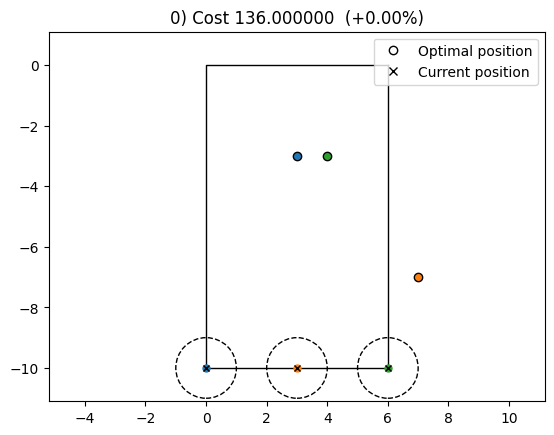

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


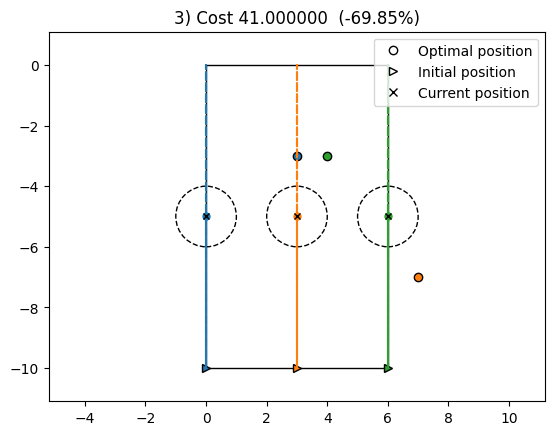

In [8]:
from openmdao.drivers.doe_generators import ListGenerator
from openmdao.drivers.doe_driver import DOEDriver

optimize(DOEDriver(ListGenerator([[('x', [0., 3., 6.]), ('y', [-10., -10., -10.])],
                                  [('x', [0., 3., 6.]), ('y', [-5., -5., -5.])],
                                  [('x', [0., 3., 6.]), ('y', [-0., -0., -0.])],
                                  ])))

#### B) Full-factorial approach


"_In statistics, a full factorial experiment is an experiment whose design consists of two or more factors, each with discrete possible values or "levels", and whose experimental units take on all possible combinations of these levels across all such factors. A full factorial design may also be called a fully crossed design. Such an experiment allows the investigator to study the effect of each factor on the response variable, as well as the effects of interactions between factors on the response variable._" [[1]](https://en.wikipedia.org/wiki/Factorial_experiment)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


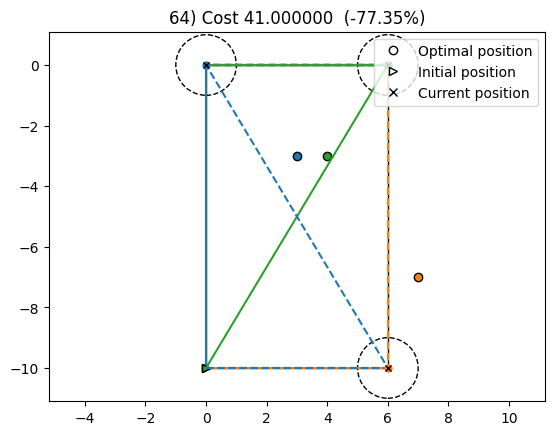

In [9]:
from openmdao.drivers.doe_generators import FullFactorialGenerator, ListGenerator
from openmdao.drivers.doe_driver import DOEDriver

optimize(DOEDriver(FullFactorialGenerator(2))) # full factorial sampling with 2 levels (2 is the default)

### Exercise

Now try to update the number of levels given as input to the `FullFactorialGenerator` to see how it affects the sampling of the design space. You will notice that, as you increase the number of levels, also the computational time increases; this is due to the full factorization which is perfomed by the generator and represents a limit in the exploration of a continuum space. 

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


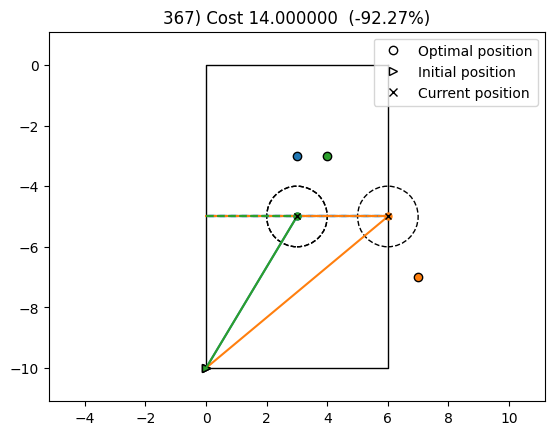

In [10]:
optimize(DOEDriver(FullFactorialGenerator(3)))

## 2) Gradient-Based Optimization with the ScipyOptimizeDriver

In this example, an openMDAO gradient-based optimization which uses the open-source Scipy algorithm **Sequential Least Squares Quadratic Programming** (or SLSQP) is presented. Indeed, the OpenMDAO library includes several built-in drivers which rely on open-sourced libraries containing optimization algorithms such as SciPy and PyOptSparse.  

Note that in TOPFARM, the OpenMDAO drivers are wrapped to further ease their usage within the framework of wind farm design optimization.

**Import the TOPFARM implementation of the Scipy optimizer and execute a gradient-based optimization.**

INFO: checking out_of_order


INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


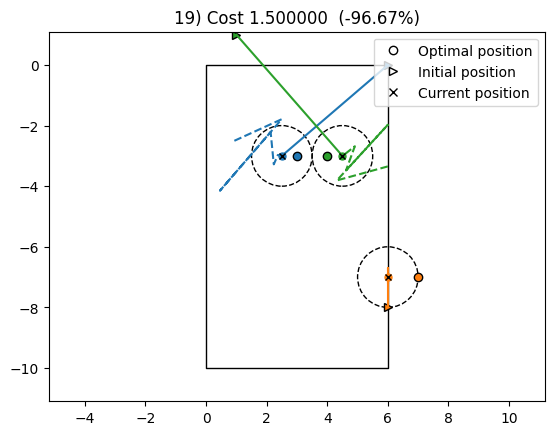

In [11]:
from topfarm.easy_drivers import EasyScipyOptimizeDriver

# setup parameters for optimization: maximum iterations and tolerance (required tolerance for establishing convergence)
optimize(EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200, tol=1e-6, disp=False))

In this example, it can be noticed that the number of iterations which are necessary to the optimization problem to converge are much less than the maximum allowed (`maxiter` $=200$). In addition, the `EasyScipyOptimizeDriver` driver looks to work much better than the `DOEdriver` for this specific Topfarm optimization problem.  

### Exercise

Now adjust the optimal positions of the wind turbines and see how the optimization performs.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


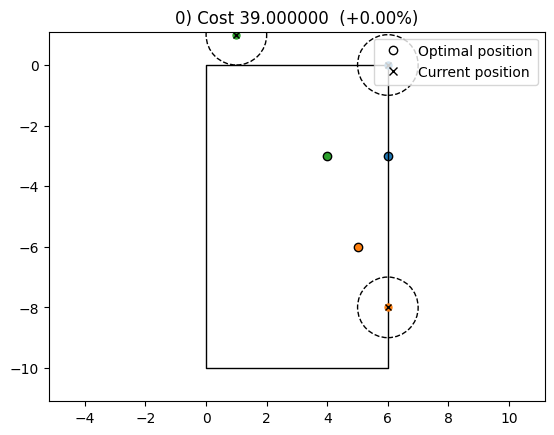

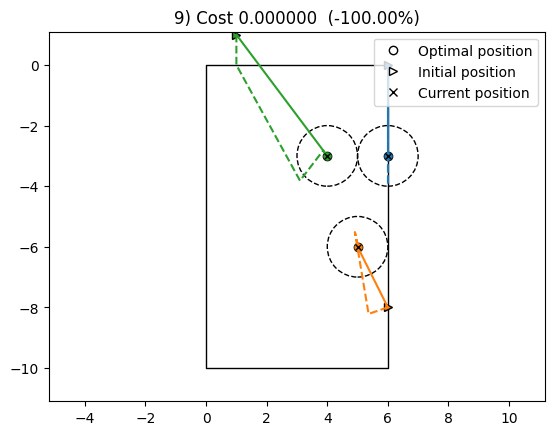

In [12]:
optimal = np.array([[6, -3, 1], [5, -6, 2], [4, -3, 4]])  # user-defined optimal turbine layouts

plot_comp = DummyCostPlotComp(optimal, delay=0.5, plot_improvements_only=True)

optimize(EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=200, tol=1e-6, disp=False))

## 3)  Gradient-Free Optimization with the ScipyOptimizeDriver

A popular **Gradient-Free Optimization Algorithm** optimization method in SciPy is the **Constrained Optimization BY Linear Approximation** (COBYLA), a local-search method which does not rely on the computation of the gradient. In particular, it performs a linear approximation of the objective function and it iterates the searching process until the optimal is found.

Now we will set up the original optimization problem from scratch and we will specifiy COBYLA as the optimization driver. The maximum number of iterations and tolerance parameters are kept the same.

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


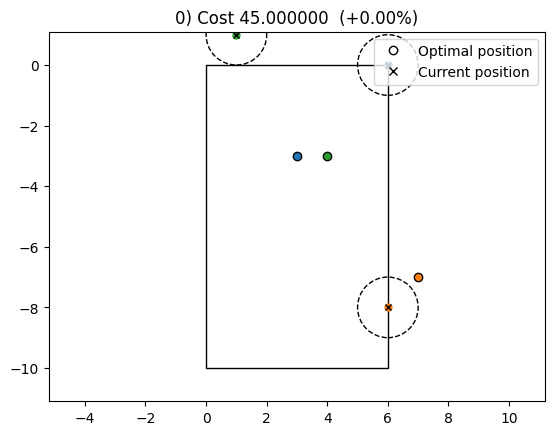

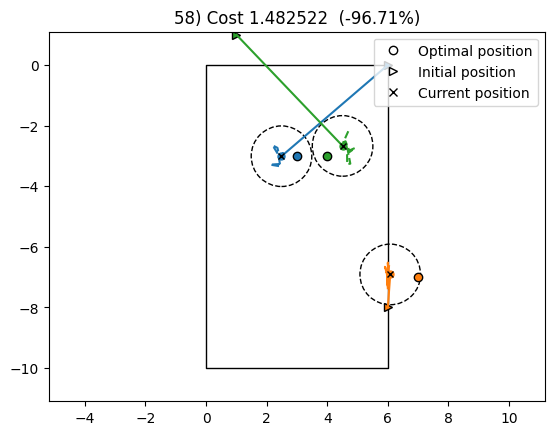

In [13]:
#set optimal back to original optimal
optimal = np.array([[3, -3, 1], [7, -7, 2], [4, -3, 4]])  # user-defined optimal turbine layouts

plot_comp = DummyCostPlotComp(optimal, delay=0.5, plot_improvements_only=True)

from topfarm.easy_drivers import EasyScipyOptimizeDriver
optimize(EasyScipyOptimizeDriver(optimizer='COBYLA', maxiter=200, tol=1e-6, disp=False))

## 4) Metaheuristic Optimization with the Genetic Algorithm (GA) driver

This example shows a simple **Genetic Algorithm metaheuristic optimization** approach. The Genetic Algorithm explores the space of the design variables much more exhaustively than the step-by-step algorithms seen above. However, such more comprehensive exploration comes at the cost of a slower convergence to the optimal solution.

**Import the TOPFARM implmentation of the GA driver and execute an optimization.**

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


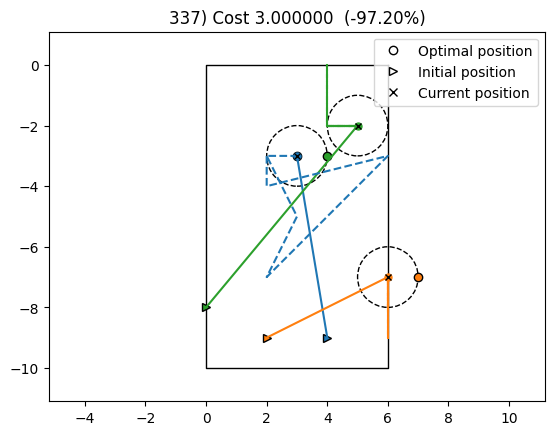

In [14]:
from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.easy_drivers import EasySimpleGADriver

# choose parameters for optimization: max_gen sets the number of iterations and pop_size sets the number of individuals in the population within each iteration
optimize(EasySimpleGADriver(max_gen=100, pop_size=5, Pm=None, Pc=.5, elitism=True, bits={}))

As just introduced, the Genetic Algorithm can be very slow; indeed, even after 100 generations, the full convergence is not achieved yet. This clearly shows the advantages of gradient-based methods for smartly probing the design space. 

## 5) Heuristic Optimization with the Easy Random-Search driver

An example of **Heuristic methods** are **Random-Search algorithms**; the Topfarm library includes a simple random-search algorithm based on the work of Ju Feng, actually Senior Researcher at DTU Wind an Energy Systems. In a few words, this recursive algorithm chooses the positions of the wind turbines at each iteration by randomly extracting two real numbers, which correspond to the euclidean norm and the angle of a reference vector. Per each iteration, the candidate solution is tested for improvement against the objective function. The reference paper, containing the major information about such algorithm, can be found at [here](https://www.sciencedirect.com/science/article/pii/S0960148115000129?via%3Dihub). 

**Set up optimization using TOPFARM implementation of random search with turbine position circle method.**

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


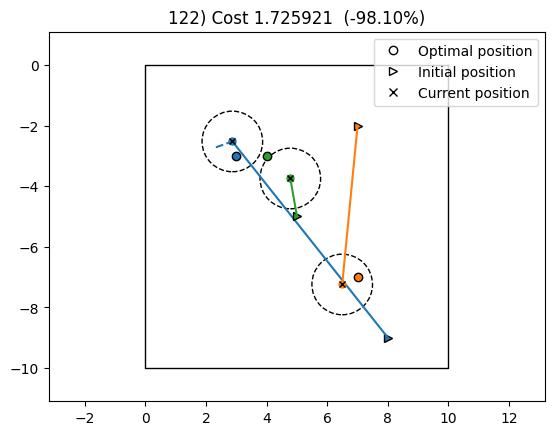

In [15]:
initial = np.array([[8, -9, 0], [7, -2, 0], [5, -5, 0]])  # user-defined initial turbine layouts
boundary = np.array([(0, 0), (10, 0), (10, -10), (0, -10)])  # user-defined site boundary vertices
optimal = np.array([[3, -3, 1], [7, -7, 2], [4, -3, 4]])  # user-defined optimal turbine layouts

from topfarm.drivers.random_search_driver import RandomizeTurbinePosition_Circle
from topfarm.easy_drivers import EasyRandomSearchDriver

# Set up key parameters of random search
# Maximum iterations max_iter sets the maximum number of iterations of the optimization
# Maximum time max_time limits execution time (so also limits the overall number of iterations)
# Maximum step max_step limits how much the design can change on a given iteration

optimize(EasyRandomSearchDriver(
    randomize_func=RandomizeTurbinePosition_Circle(max_step=5), 
    max_iter=100, 
    max_time=1000, 
    disp=False))

This example shows that, weather the Heuristic Random-Search algorithm from J. Feng takes less iterations with respect to the Metaheuristic GA, it's still slower than gradient-based methods. However, it remains of great importance to have Heuristic and Metaheuristic methods at our disposal, as they are more powerful in the face of complex functions with many local minima and plateaux, where gradient-based methods easily fail.